<a href="https://colab.research.google.com/github/NataliaKolesnik/Intergalactic_hackathon/blob/master/3_RZD_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Предсказание: Успеет ли произойти технологический процесс от изъятия вагона до включения в поезд в течении 36 часов вемени**

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # для сохранения модели

In [3]:
# Импорт библиотек для обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, auc

In [4]:
import catboost
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *

In [5]:
# Загрузка данных из Наташиного csv файла

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RZD/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Датасет, полученный на этапе анализа, в которм отобраны только операции, удовлетворяющие нашим условиям
data = pd.read_csv(path + 'data_34.csv')

In [7]:
data

,станция,вагон,операция_первая,операция_последняя,все_операции,количество_операций,время_первой_операции,время_последней_операции,разница_времени,станция_назначения,опасный_груз,код_груза,род_вагона,вес_тары_вагона,изм_станции,длительность,длительность_час,ст_опер_кол_ваг,ранг_станции
0,830003,24579856,3,4,"[3, 80, 19, 81, 4, 3, 18, 4]",8,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003,0.0,0,20.0,NaN,0,2 days 11:24:00,59.400000,1155,4
1,830003,24622276,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003,0.0,0,20.0,NaN,0,1 days 04:55:00,28.916667,1155,4
2,830003,28034288,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-25 00:21:00,2020-07-28 05:40:00,3 days 05:19:00,830003,0.0,0,20.0,NaN,0,3 days 05:19:00,77.316667,1155,4
3,830003,28035723,3,4,"[3, 81, 4]",3,2020-07-23 16:57:00,2020-07-25 08:47:00,1 days 15:50:00,830003,0.0,0,20.0,NaN,0,1 days 15:50:00,39.833333,1155,4
4,830003,29019288,3,4,"[3, 18, 4]",3,2020-07-24 20:51:00,2020-07-28 02:00:00,3 days 05:09:00,830003,0.0,0,20.0,NaN,0,3 days 05:09:00,77.150000,1155,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333668,998100,61320917,3,4,"[3, 78, 20, 18, 79, 4]",6,2020-07-07 15:07:00,2020-07-12 01:30:00,4 days 10:23:00,998100,0.0,0,60.0,NaN,0,4 days 10:23:00,106.383333,95,2
333669,998100,62175377,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2
333670,998100,63750566,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2
333671,998100,66288432,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2


In [8]:
data['st_vag'] = data.apply(lambda row: (row.станция, row.вагон), axis=1)

Так как у нас бинарная классификация, то создаем целевую переменну. 

    1 - успеет за 36 часов
    0 - не успеет за 36 часов

In [9]:
data['присоединение_36ч'] = data['длительность_час'].apply(lambda x: 1 if x <= 36 else 0)

In [10]:
# длитеность в технол. процесса по количеству оперций
data['количество_операций'].max()

127

Максимальное количество операций 127, но при анализе мы выяснили, что технологический процесс до 36 укладывается в 12 операций. Поэтому целесообразно взять чуть больше, например 20.

In [11]:
oper = data['все_операции'].values
i =  20  # Количество признаков - операций
for el in range(oper.shape[0]):
    x = oper[el].replace('[','').replace(']','').split(',')
    x = [int(j) for j in x]
    if len(x) >= i:
        oper[el] = np.array(x[:i])
    else:
        k0 = i - len(x)
        x=x+[0]*k0 
        oper[el] = np.array(x[:i])

In [12]:
proc = {}
col = ['опер.№_'+str(i) for i in range(20)]
for el in range(len(col)):
    proc[col[el]] = [oper[i][el] for i in range(oper.shape[0])]


In [13]:
# Датасет технологических операции
df_tex_proc = pd.DataFrame(proc)

In [14]:
# Сформируем из ДатаСета выборку признаков
data_tr = data[['st_vag', 'ранг_станции', 'изм_станции', 'количество_операций', 'ст_опер_кол_ваг' ,'присоединение_36ч']].copy()

In [15]:
# Сконкотенируем два ДатаСета
data_tr = pd.concat([data_tr, df_tex_proc], axis=1)

In [16]:
# Получили готовый для обучения датасет
data_tr

,st_vag,ранг_станции,изм_станции,количество_операций,ст_опер_кол_ваг,присоединение_36ч,опер.№_0,опер.№_1,опер.№_2,опер.№_3,...,опер.№_10,опер.№_11,опер.№_12,опер.№_13,опер.№_14,опер.№_15,опер.№_16,опер.№_17,опер.№_18,опер.№_19
0,"(830003, 24579856)",4,0,8,1155,0,3,80,19,81,...,0,0,0,0,0,0,0,0,0,0
1,"(830003, 24622276)",4,0,6,1155,1,3,80,28,19,...,0,0,0,0,0,0,0,0,0,0
2,"(830003, 28034288)",4,0,6,1155,0,3,80,28,19,...,0,0,0,0,0,0,0,0,0,0
3,"(830003, 28035723)",4,0,3,1155,0,3,81,4,0,...,0,0,0,0,0,0,0,0,0,0
4,"(830003, 29019288)",4,0,3,1155,0,3,18,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333668,"(998100, 61320917)",2,0,6,95,0,3,78,20,18,...,0,0,0,0,0,0,0,0,0,0
333669,"(998100, 62175377)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0
333670,"(998100, 63750566)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0
333671,"(998100, 66288432)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Распределение по классам неравномерное. Учтем при разбиении на тренировочную и тестовую выборки
data_tr['присоединение_36ч'].value_counts(normalize=True)

0    0.703407
1    0.296593
Name: присоединение_36ч, dtype: float64

In [18]:
data_tr[data_tr['присоединение_36ч'] == 1].sample(20)

,st_vag,ранг_станции,изм_станции,количество_операций,ст_опер_кол_ваг,присоединение_36ч,опер.№_0,опер.№_1,опер.№_2,опер.№_3,...,опер.№_10,опер.№_11,опер.№_12,опер.№_13,опер.№_14,опер.№_15,опер.№_16,опер.№_17,опер.№_18,опер.№_19
329138,"(987708, 65174211)",5,1,5,6902,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
32834,"(862108, 62544168)",6,0,3,11500,1,3,18,4,0,...,0,0,0,0,0,0,0,0,0,0
56987,"(864207, 54180658)",6,0,6,13178,1,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0
227885,"(967600, 58584012)",6,1,7,27130,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
294460,"(985906, 52803772)",6,1,5,43702,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
288243,"(985609, 56142938)",6,1,5,12785,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
287809,"(985609, 55651319)",6,1,5,12785,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
45141,"(863007, 57900342)",6,0,4,26287,1,3,80,10,4,...,0,0,0,0,0,0,0,0,0,0
309843,"(985906, 62697073)",6,1,5,43702,1,3,80,21,81,...,0,0,0,0,0,0,0,0,0,0
72846,"(870405, 43824770)",4,0,5,1763,1,3,80,21,18,...,0,0,0,0,0,0,0,0,0,0


## Обучение

In [19]:
def metrics(y_test, y_pred):
    """Комплексный расчет метрик"""
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred).round(4)
    recall = recall_score(y_test, y_pred).round(4)
    roc_auc = roc_auc_score(y_test, y_pred).round(4)
    f1 = f1_score(y_test, y_pred).round(4)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Если необходимо вывести метрики на печать - раскомментировать
    print('Матрица:')
    print(conf_matrix)
    print('точность (precision) - ', precision)
    print('полнота (recall) -', recall)
    print('roc_auc - ', roc_auc)
    print('f1_score - ', f1)
    print('accuracy - ', accuracy)

    
    #return {'conf_matrix': conf_matrix, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc, 'f1': f1}

In [20]:
RANDOM_STATE = 42

In [21]:
# Разбиваем на признаки и целевую переменную
X = data_tr.drop(['st_vag', 'присоединение_36ч'], axis=1)
Y = data_tr['присоединение_36ч']


In [22]:
# Разобъем нашу выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=Y)

In [23]:
# Разделим X_train на тестовую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=Y_train)

## RandomForestClassifier

In [24]:
# Для таких признаков лучше всего подойдет модель Смешанный лес. 
# Так как Смешаннй лес не чуствительный к разному масштабу данных, то масштабировать данные не будем.

In [25]:
clf_RFC = RandomForestClassifier(n_estimators=15, random_state=RANDOM_STATE)
clf_RFC = clf_RFC.fit(X_train, Y_train)
Y_pred = clf_RFC.predict(X_test)
metrics(Y_test, Y_pred)

Матрица:
[[42187  4755]
 [ 4733 15060]]
точность (precision) -  0.76
полнота (recall) - 0.7609
roc_auc -  0.8298
f1_score -  0.7605
accuracy -  0.8578257286281561


**Метрики качества:**

Точность и полнота получились сбалансированными между собой и составляют по 76%.  
Что так же видно и по конфигурационной матрице ошиок.

accuracy (доляверных ответов) - 86%

In [78]:
# метрики с учетом границы - мы можем выбирать в чем нам лучше ошибиться
vf = np.vectorize(lambda x: 1 if x > 0.35 else 0)
Y_pred_with_probability = vf(clf_RFC.predict_proba(X_test)[:,1])

metrics(Y_test, Y_pred_with_probability)

Матрица:
[[39554  7388]
 [ 2860 16933]]
точность (precision) -  0.6962
полнота (recall) - 0.8555
roc_auc -  0.8491
f1_score -  0.7677
accuracy -  0.8464374016632952


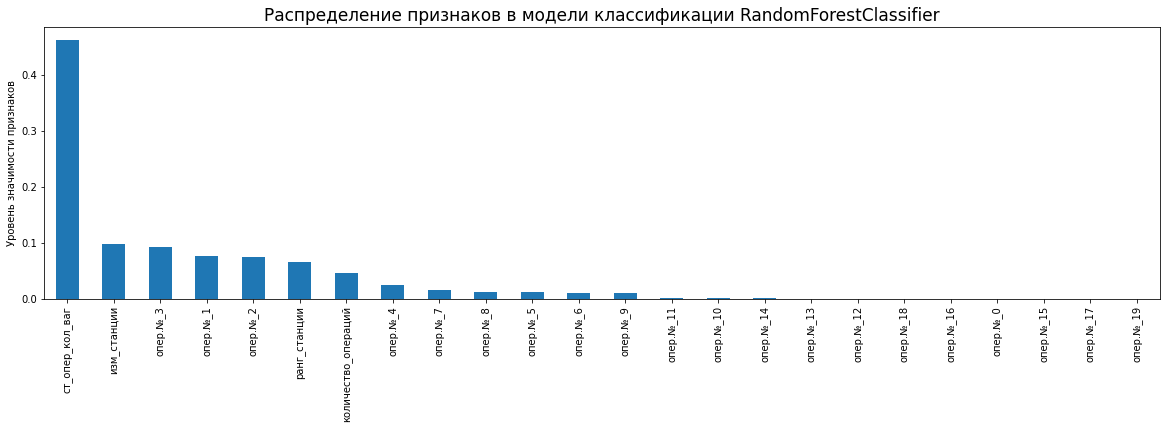

In [26]:
RF_feaches = pd.Series(clf_RFC.feature_importances_)
RF_feaches.index = X.columns
RF_feaches = RF_feaches.sort_values(ascending=False)

RF_feaches.plot.bar(figsize=(20,5))
plt.ylabel('Уровень значимости признаков')
plt.title('Распределение признаков в модели классификации RandomForestClassifier', fontsize = 17)
plt.show()

**Наиболее важными признаками модель определила:**
1. Пропускная способность станции (сколько она обслужила вагонов в месяце)
2. Конечная эта или транзитная станция
3. Первые операции технологического процесса (1-4)
4. Ранг станции - это распределение станций по группам, в зависимости от пропускной способности
5. Количество операций технологического процесса над вагоном 

Эти же признаки нами выявили и в результате анализа данных.



In [27]:
# Считает долго - без нужды не запускать
# # Подбор гиперпараметров
# n_estimators = [10, 25, 40, 60,75]
# max_features = [4,6,8,10]
# max_depth = [2,3,7,11,15]
# min_samples_split = [2,3,4,22,23,24]
# min_samples_leaf = [2,3,4,5,6,7]
# bootstrap = [False]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# gs = GridSearchCV(clf_RFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_valid, Y_valid)
# clf_RFC = gs.best_estimator_
# gs.best_params_

In [28]:
clf_RFC_bp = RandomForestClassifier(n_estimators=60, 
                                    bootstrap=False,
                                    max_depth=15,
                                    max_features=10,
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    random_state=RANDOM_STATE)
clf_RFC_bp = clf_RFC_bp.fit(X_train, Y_train)
Y_pred = clf_RFC_bp.predict(X_test)
metrics(Y_test, Y_pred)

Матрица:
[[43210  3732]
 [ 6388 13405]]
точность (precision) -  0.7822
полнота (recall) - 0.6773
roc_auc -  0.7989
f1_score -  0.726
accuracy -  0.8483554356784296


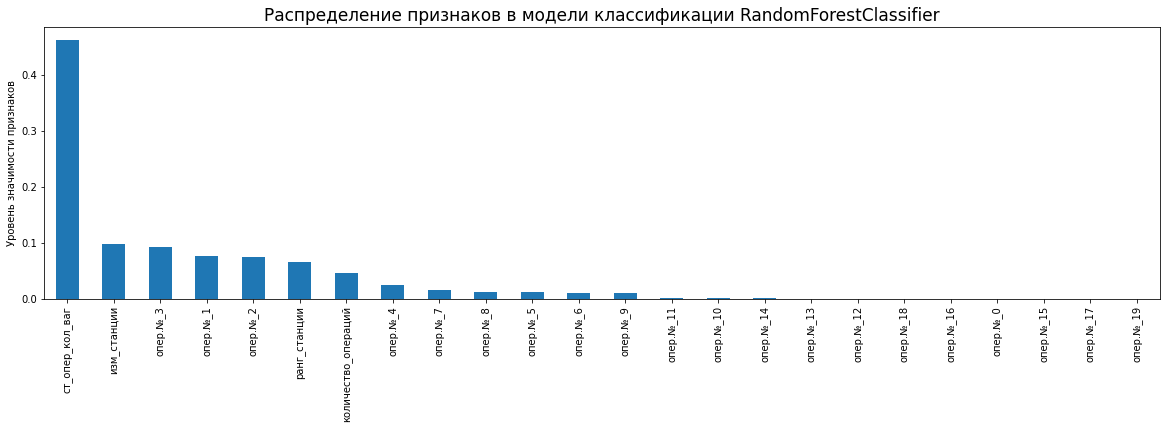

In [29]:
RF_feaches = pd.Series(clf_RFC.feature_importances_)
RF_feaches.index = X.columns
RF_feaches = RF_feaches.sort_values(ascending=False)

RF_feaches.plot.bar(figsize=(20,5))
plt.ylabel('Уровень значимости признаков')
plt.title('Распределение признаков в модели классификации RandomForestClassifier', fontsize = 17)
plt.show()

Гиперпараметры картину не изменили, а даже ухудшили по многим метрикам. Распределение признаков осталось прежнем. Оставим базовую модель



**Сохранение модели в файл**

In [30]:
with open(path+'model_clf_RFC.pkl', 'wb') as file:
    pickle.dump(clf_RFC, file)

In [31]:
X_test.to_csv(path+'X_test.csv', index=False)
Y_test.to_csv(path+'Y_test.csv', index=False)

## Catboost

In [32]:

# from catboost import CatBoostClassifier, Pool, FeaturesData, MetricVisualizer, cv
# from catboost.utils import create_cd, get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
# from catboost.eval.catboost_evaluation import *
# from catboost.eval.evaluation_result import *
# import shap
# import matplotlib.pyplot as plt

# np.set_printoptions(precision=3)


In [33]:
# Catboost необходимо сказать, какие признаки категориальные - сделаем массив с индексами категориальных фичей
# В нашем датасете это все, кроме 'ст_опер_кол_ваг' - индекс 3
cat_features = list(range(0, X.shape[1])) # Датасет X - без targetа
if 3 in cat_features:
    cat_features.remove(3)
print(cat_features)   

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [37]:
model_CBclass = CatBoostClassifier(
    iterations=1000, # число итераций
    learning_rate=0.01, # шаг
    l2_leaf_reg=3, # делает так, чтобы листья в дереве не становились бесконечностью
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton', # метод по которому будем подбирать значения в листьях
    loss_function = 'Logloss',
    custom_loss=['AUC', 'Accuracy'],
    random_seed = RANDOM_STATE, 
    metric_period=25, # вывод информации о процессе обучения более компактный (через сколько итераций, и для графиков это тоже работает)
)

model_CBclass.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_valid, Y_valid),
    verbose=25,
    plot=True # график в colab не строится, а в juputer можно посмотрть,запустив этот код
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6876768	test: 0.6876941	best: 0.6876941 (0)	total: 3.22s	remaining: 53m 38s
25:	learn: 0.5845020	test: 0.5849457	best: 0.5849457 (25)	total: 27.4s	remaining: 17m 6s
50:	learn: 0.5311263	test: 0.5319168	best: 0.5319168 (50)	total: 48.8s	remaining: 15m 8s
75:	learn: 0.5000935	test: 0.5011637	best: 0.5011637 (75)	total: 1m 9s	remaining: 14m 9s
100:	learn: 0.4819308	test: 0.4830958	best: 0.4830958 (100)	total: 1m 32s	remaining: 13m 40s
125:	learn: 0.4684639	test: 0.4699466	best: 0.4699466 (125)	total: 1m 54s	remaining: 13m 16s
150:	learn: 0.4573017	test: 0.4589870	best: 0.4589870 (150)	total: 2m 17s	remaining: 12m 54s
175:	learn: 0.4485848	test: 0.4503511	best: 0.4503511 (175)	total: 2m 39s	remaining: 12m 27s
200:	learn: 0.4422035	test: 0.4440866	best: 0.4440866 (200)	total: 3m 2s	remaining: 12m 4s
225:	learn: 0.4372749	test: 0.4392652	best: 0.4392652 (225)	total: 3m 23s	remaining: 11m 38s
250:	learn: 0.4328428	test: 0.4349361	best: 0.4349361 (250)	total: 3m 45s	remaining: 11m 

In [38]:
print('Количесвто деревьев:', model_CBclass.tree_count_)

Количесвто деревьев: 1000


In [39]:
# метрики 
metrics(Y_test, model_CBclass.predict(X_test))

Матрица:
[[43054  3888]
 [ 7627 12166]]
точность (precision) -  0.7578
полнота (recall) - 0.6147
roc_auc -  0.7659
f1_score -  0.6788
accuracy -  0.8274518618416123


In [40]:
eval_pool = Pool(X_valid, Y_valid, cat_features)
curve = get_roc_curve(model_CBclass, eval_pool)# возвращает 3 массива
(fpr, tpr, thresholds) = curve 
# thresholds - граница принятия решения к какому классу отнести от 0 до 1
# fpr, tpr - вектора, которые этим границам соответсвуют
roc_auc = auc(fpr, tpr)

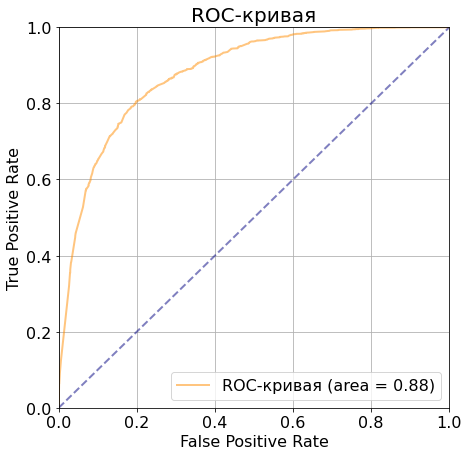

In [41]:
plt.figure(figsize=(7, 7))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label="ROC-кривая (area = %0.2f)" % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-кривая', fontsize=20)
plt.legend(loc='lower right',  fontsize=16)
plt.show()

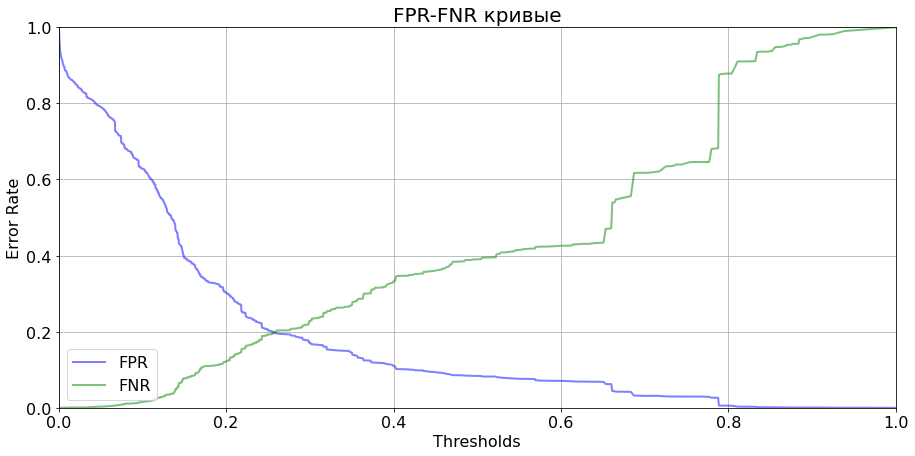

In [42]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(15, 7))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR кривые', fontsize=20)
plt.legend(loc='lower left',  fontsize=16)
plt.show()

In [43]:
# Выбор границы
print('Если хотим ошибаться в 5% положительного класса - threshold = ', end='' )
print(select_threshold(model=model_CBclass, data=eval_pool, FNR=0.05))
print('Если хотим ошибаться в 5% отрицательного класса - threshold = ', end='' )
print(select_threshold(model=model_CBclass, data=eval_pool, FPR=0.05))

Если хотим ошибаться в 5% положительного класса - threshold = 0.1410577875667623
Если хотим ошибаться в 5% отрицательного класса - threshold = 0.6613807375694891


In [44]:
# важность признаков модели - на сколько эта фича важна
model_CBclass.get_feature_importance(prettified=True)

,Feature Id,Importances
0,ст_опер_кол_ваг,25.267956
1,опер.№_7,16.636402
2,опер.№_2,10.036059
3,опер.№_4,8.128971
4,изм_станции,7.760507
5,опер.№_5,6.357477
6,опер.№_1,6.343687
7,опер.№_3,5.101647
8,опер.№_9,4.124572
9,ранг_станции,3.766838


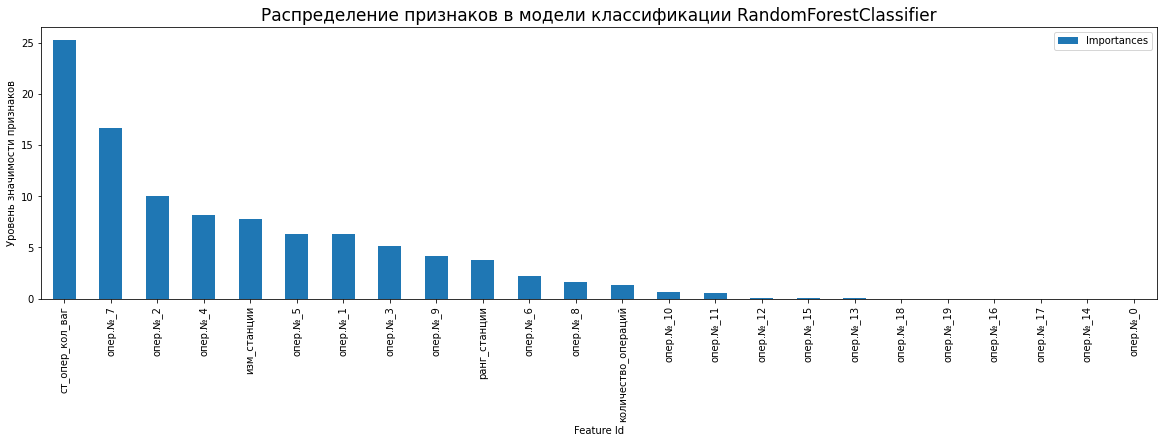

In [71]:
CB_feaches = model_CBclass.get_feature_importance(prettified=True)
CB_feaches.index = CB_feaches['Feature Id']
CB_feaches.plot.bar(figsize=(20,5))
plt.ylabel('Уровень значимости признаков')
plt.title('Распределение признаков в модели классификации CatBoostClassifier', fontsize = 17)
plt.show()

In [77]:
# метрики с учетом границы - мы можем выбирать в чем нам лучше ошибиться
vf = np.vectorize(lambda x: 1 if x > 0.25 else 0)
Y_pred_with_probability = vf(model_CBclass.predict(X_test, prediction_type='Probability')[:, 1])

metrics(Y_test, Y_pred_with_probability)

Матрица:
[[37299  9643]
 [ 3710 16083]]
точность (precision) -  0.6252
полнота (recall) - 0.8126
roc_auc -  0.8036
f1_score -  0.7066
accuracy -  0.7999100921555405


In [ ]:
# Метрики 50/50, т.е. граница 0,5
# Матрица:
# [[43054  3888]
#  [ 7627 12166]]
# точность (precision) -  0.7578
# полнота (recall) - 0.6147
# roc_auc -  0.7659
# f1_score -  0.6788
# accuracy -  0.8274518618416123

**Сохранение модели**

In [69]:
model_CBclass.save_model(path+'model_CBclass.bin')